In [1]:
!pip install -U -q catboost

In [2]:
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor, 
    ExtraTreesRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import (
    Ridge,
    Lasso,
    RidgeCV,
    LassoCV
)
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings
import optuna
import re

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

SEED = 27
N_FOLDS = 5
N_REPEATS = 5
N_OPTUNA_TRIALS = 50

In [3]:
dataset = pd.read_csv('/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv')
dataset = dataset.dropna(subset=['lønn'])

In [4]:
dataset

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
...,...,...,...,...,...,...,...,...,...,...
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja


# Topp 10 best betalte

In [5]:
dataset.sort_values(by='lønn', ascending=False).head(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
2305,46-50,5.0,22.0,"in-house, privat sektor",Oslo,ledelse/administrativt,100 - 500,3500000.0,Ja,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2300,36-40,5.0,12.0,"in-house, privat sektor",Oslo,ledelse/administrativt,over 10.000,2500000.0,Ja,Ja
2299,26-30,5.0,5.0,frilans / selvstendig næringsdrivende,utlandet,sikkerhet,50 - 100,2500000.0,Ja,Ja
2298,51-55,3.0,29.0,konsulent,Oslo,fullstack,10 - 50,2500000.0,Ja,Ja
2297,31-35,3.0,10.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,2330000.0,Nei,Ja
2295,26-30,3.0,5.0,frilans / selvstendig næringsdrivende,Oslo,fullstack,under 10,2300000.0,Nei,Ja


# Topp 10 dårlegast betalte

In [6]:
dataset.sort_values(by='lønn', ascending=False).tail(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
7,15-20,1.0,0.0,"in-house, privat sektor",Trøndelag,programvare,10 - 50,360000.0,Nei,Nei
10,21-25,0.0,4.0,konsulent,Viken,app,under 10,360000.0,Nei,Nei
11,46-50,NaN,32.0,"in-house, privat sektor",Innlandet,ledelse/administrativt,under 10,360000.0,Ja,Nei
6,26-30,0.0,1.0,"in-house, privat sektor",Troms og Finnmark,fullstack,10 - 50,352000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
5,36-40,NaN,10.0,frilans / selvstendig næringsdrivende,Vestland,ingen av disse,under 10,350000.0,Nei,Nei
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja


# Best betalte stillinger

In [7]:
avg_salaries_by_job_type = dataset.groupby('fag')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_job_type,
    y='fag', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'fag': 'Fag', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_job_type.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['fag'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [8]:
avg_salary_by_fag = dataset.groupby('fag')['lønn'].mean().reset_index()
sorted_fag = avg_salary_by_fag.sort_values(by='lønn', ascending=True)['fag']
dataset_sorted = dataset.set_index('fag').loc[sorted_fag].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='fag',    
    width=800, 
    height=400
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fag',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Kvar lønnar det seg å jobbe?

In [9]:
avg_salaries_by_city = dataset.groupby('sted')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_city,
    y='sted', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'sted': 'Fylke', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fylke',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_city.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['sted'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [10]:
avg_salary_by_city = dataset.groupby('sted')['lønn'].mean().reset_index()
sorted_city = avg_salary_by_city.sort_values(by='lønn', ascending=True)['sted']
dataset_sorted = dataset.set_index('sted').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='sted',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fylke',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Erfaring og utdanning

In [11]:
cleaned_data = dataset.dropna(subset=['erfaring', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_experience = cleaned_data.groupby('erfaring')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmin()]
highest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_experience,
    x='erfaring',
    y='lønn',
    labels={'erfaring': 'Erfaring', 'lønn': 'Gjennomsnittsløn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['erfaring']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Erfaring: {int(lowest_point["erfaring"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['erfaring']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Erfaring: {int(highest_point["erfaring"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top center'
    )
)

fig.update_layout(
    xaxis_title='Erfaring',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

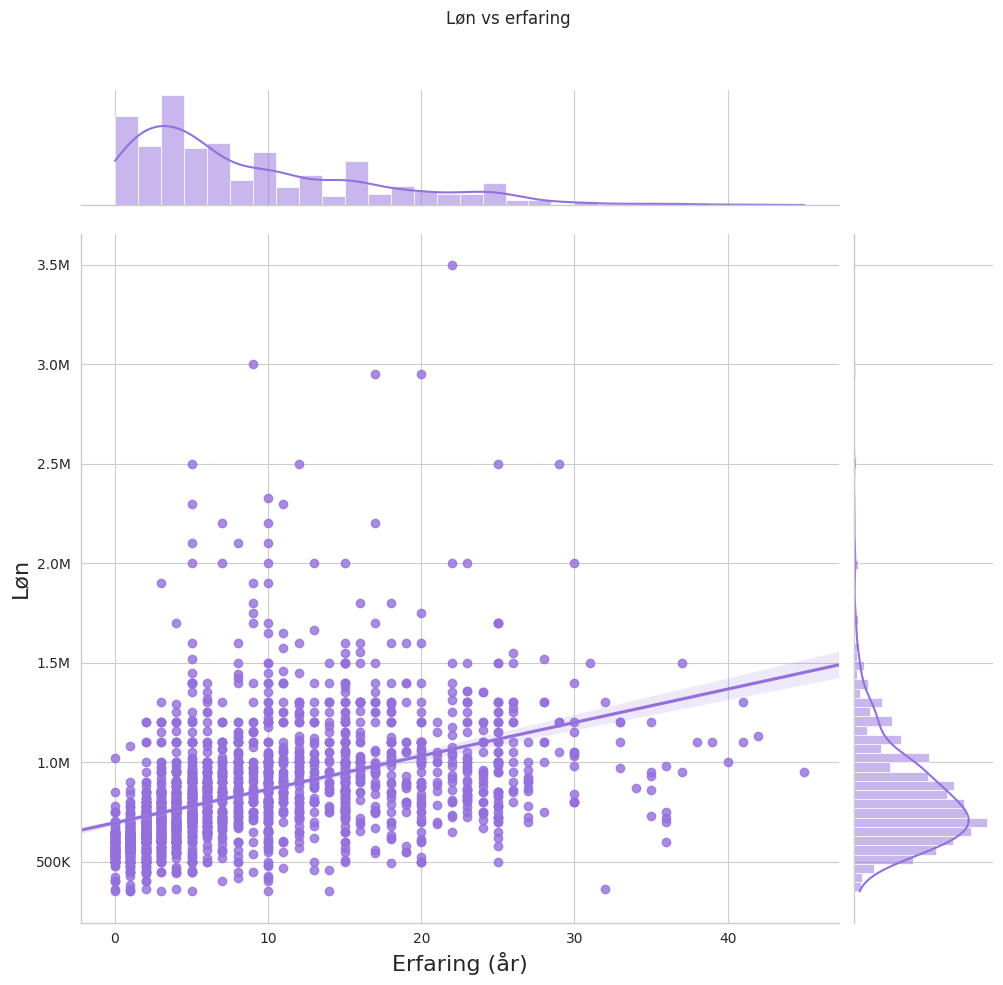

In [12]:
def currency_format(x, pos):
    'The two args are the value and tick position'
    if x >= 1e6:
        s = '{:.1f}M'.format(x*1e-6)
    else:
        s = '{:.0f}K'.format(x*1e-3)
    return s

sns.set_style('whitegrid')
g = sns.jointplot(
    x='erfaring',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10,
)
g.set_axis_labels('Erfaring (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs erfaring')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

In [13]:
cleaned_data = dataset.dropna(subset=['utdanning', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_edu = cleaned_data.groupby('utdanning')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmin()]
highest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_edu,
    x='utdanning',
    y='lønn',
    labels={'utdanning': 'Utdanning', 'lønn': 'Gjennomsnittslønn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['utdanning']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Utdanning: {int(lowest_point["utdanning"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['utdanning']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Utdanning: {int(highest_point["utdanning"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top left'
    )
)

fig.update_layout(
    xaxis_title='Utdanning',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

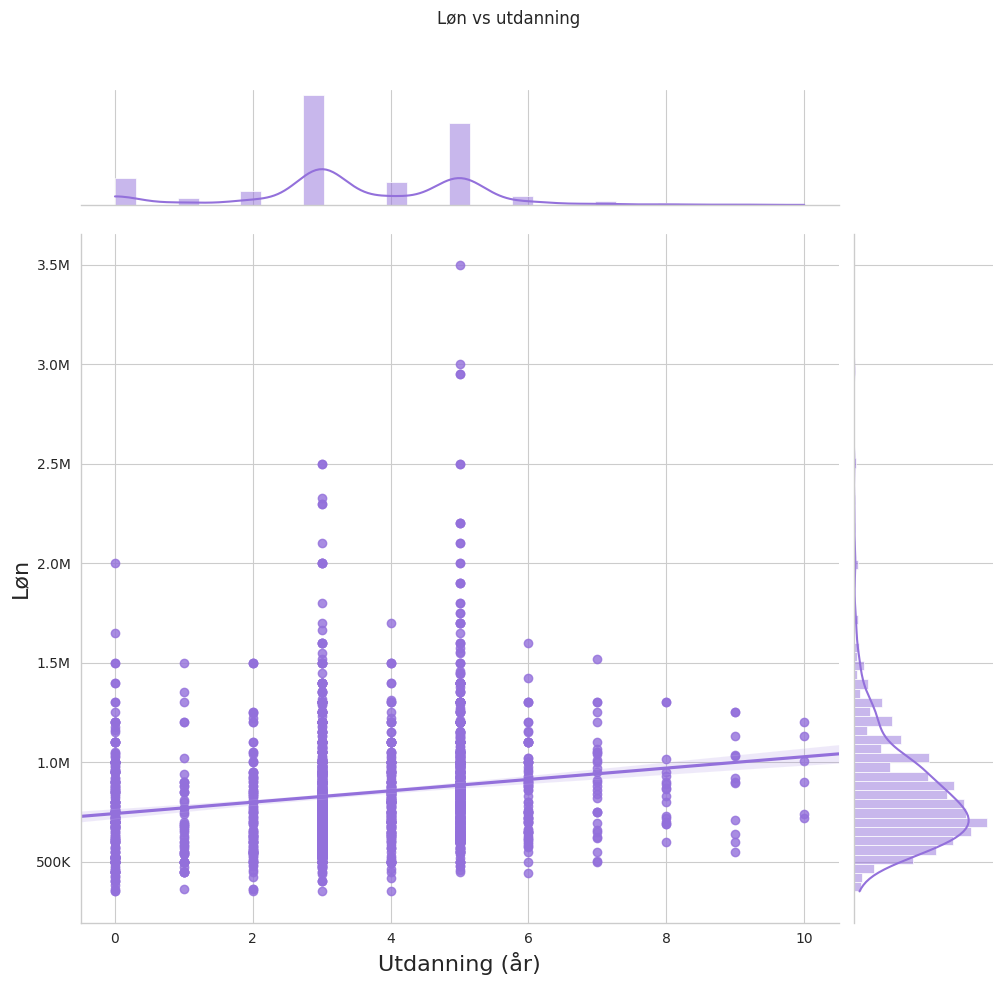

In [14]:
sns.set_style('whitegrid')
g = sns.jointplot(
    x='utdanning',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10
)
g.set_axis_labels('Utdanning (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs utdanning')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

# Privat, offentleg, konsulent, eller frilans

In [15]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_employer,
    y='jobb', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'jobb': 'Jobb', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Jobb',
    width=800,
    height=400,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_employer.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['jobb'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [16]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_employer.sort_values(by='lønn', ascending=True)['jobb']
dataset_sorted = dataset.set_index('jobb').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='jobb',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Jobb',  
    font=dict(size=10)    
)

fig.show()

# Korrelasjon mellom lønn og andre variablar

In [17]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

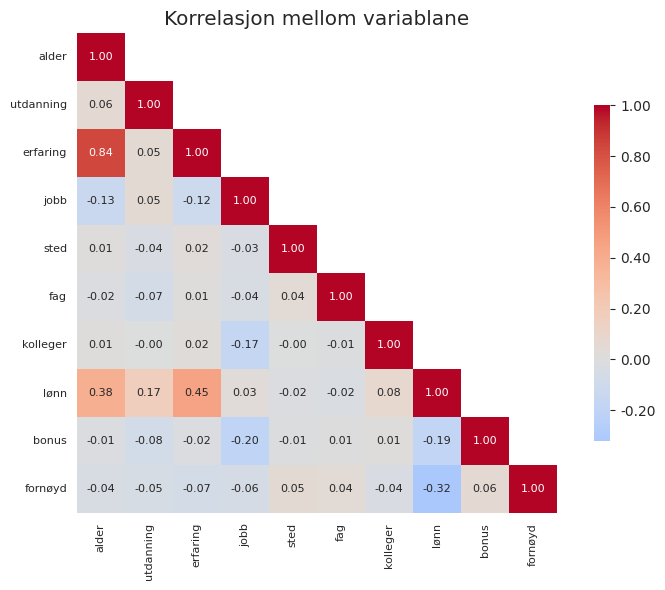

In [18]:
corr_train = dataset.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)
ax.set_title('Korrelasjon mellom variablane')
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Prediksjon av løn

In [19]:
dataset = pd.read_csv('/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv')
dataset["is_train"] = True

In [20]:
test_data = {
    'alder': ['26-30'],
    'utdanning': [5.0],
    'erfaring': [2.0],
    'jobb': ['in-house, privat sektor'],
    'sted': ['Vestland'],
    'fag': ['backend'],
    'kolleger': ['50 - 100'],
    'lønn': [0],
    'bonus': ['Ja'],
    'fornøyd': ['Ja'],
    'is_train': [False]
}

test_data = pd.DataFrame(test_data)
dataset = pd.concat([dataset, test_data])

In [21]:
dataset = dataset.dropna(subset=['lønn', 'alder'])

dataset['utdanning'] = dataset['utdanning'].fillna(dataset['utdanning'].mode()[0])
dataset['erfaring'] = dataset['erfaring'].fillna(dataset['erfaring'].mode()[0])  

dataset = pd.get_dummies(data=dataset, columns=['alder', 'jobb', 'sted', 'fag', 'kolleger', 'bonus', 'fornøyd'])
dataset = dataset.rename(columns = lambda x:re.sub('[^A-ZÆØÅa-zæøå0-9_-]+', '', x))

In [22]:
train = dataset[dataset["is_train"] == True]
test = dataset[dataset["is_train"] == False]

train = train.drop(columns=['is_train'])
test = test.drop(columns=['is_train', 'lønn'])

train.shape, test.shape

((2306, 56), (1, 55))

In [23]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [24]:
X = train.drop(columns='lønn')
y = train['lønn']

In [25]:
def cb_objective(trial):
    params = {
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
        'depth': trial.suggest_int('depth', 1, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 100.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'iterations': trial.suggest_int('iterations', 100, 1000),        
        'random_state': SEED,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

cb_params = study.best_params
cb_params['random_state'] = SEED
cb_params['verbose'] = False

[I 2024-06-10 13:53:53,687] A new study created in memory with name: no-name-8dab7169-bac7-4ee6-8061-2bb374310818
[I 2024-06-10 13:54:32,299] Trial 1 finished with value: 0.4154438704222515 and parameters: {'random_strength': 38.038441309338246, 'depth': 8, 'learning_rate': 0.2789413112733643, 'l2_leaf_reg': 8.974432818215618, 'bagging_temperature': 32.46099690747247, 'border_count': 32, 'iterations': 509}. Best is trial 1 with value: 0.4154438704222515.
[I 2024-06-10 13:54:48,042] Trial 3 finished with value: 0.40597784271419546 and parameters: {'random_strength': 83.64045935913936, 'depth': 8, 'learning_rate': 0.2505289602390583, 'l2_leaf_reg': 9.055519405986827, 'bagging_temperature': 84.76900625712328, 'border_count': 95, 'iterations': 723}. Best is trial 1 with value: 0.4154438704222515.
[I 2024-06-10 13:54:57,541] Trial 5 finished with value: 0.4783293740093574 and parameters: {'random_strength': 66.28888992999137, 'depth': 1, 'learning_rate': 0.21253333046244313, 'l2_leaf_reg': 

In [26]:
def lgb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': SEED,
        'verbosity': -1
    }
    
    model = LGBMRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(lgb_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

lgb_params = study.best_params
lgb_params['random_state'] = SEED
lgb_params['verbosity'] = -1

[I 2024-06-10 14:40:56,370] A new study created in memory with name: no-name-6f9f082e-66ff-4966-a4a5-c551c31c3844
[I 2024-06-10 14:40:59,808] Trial 1 finished with value: 0.48627391048615765 and parameters: {'max_depth': 2, 'num_leaves': 148, 'learning_rate': 0.22762496766571683, 'n_estimators': 412, 'min_child_samples': 48, 'subsample': 0.3720064633890472, 'colsample_bytree': 0.8289670715752205, 'reg_alpha': 1.464181811127384, 'reg_lambda': 9.747706406963374}. Best is trial 1 with value: 0.48627391048615765.
[I 2024-06-10 14:41:02,745] Trial 0 finished with value: 0.4918812485270017 and parameters: {'max_depth': 3, 'num_leaves': 224, 'learning_rate': 0.07291344140644994, 'n_estimators': 633, 'min_child_samples': 69, 'subsample': 0.40947877462228754, 'colsample_bytree': 0.7654484631763803, 'reg_alpha': 3.1415940888891036, 'reg_lambda': 7.239022814903938}. Best is trial 0 with value: 0.4918812485270017.
[I 2024-06-10 14:41:04,544] Trial 4 finished with value: 0.4056343777746941 and para

In [27]:
def gb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'alpha': trial.suggest_float('alpha', 0.0, 0.99),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 10.0),
        'random_state': SEED,
        'verbose': 0
    }
    
    model = GradientBoostingRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(gb_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

gb_params = study.best_params
gb_params['random_state'] = SEED
gb_params['verbose'] = 0

[I 2024-06-10 14:42:11,303] A new study created in memory with name: no-name-3c4e3b29-0062-4656-a890-c758b3bbf5f9
[I 2024-06-10 14:43:17,132] Trial 0 finished with value: 0.4392442643131792 and parameters: {'max_depth': 6, 'n_estimators': 437, 'learning_rate': 0.07573076341857882, 'subsample': 0.2299924916551488, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.6422750712282854, 'alpha': 0.421865175250287, 'ccp_alpha': 3.3070480315519957}. Best is trial 0 with value: 0.4392442643131792.
[I 2024-06-10 14:43:23,733] Trial 2 finished with value: 0.40762491302604625 and parameters: {'max_depth': 6, 'n_estimators': 291, 'learning_rate': 0.07360122645012661, 'subsample': 0.7299822960905757, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.8369841177980055, 'alpha': 0.7774710278200766, 'ccp_alpha': 0.21118500174743593}. Best is trial 0 with value: 0.4392442643131792.
[I 2024-06-10 14:43:44,768] Trial 1 finished with value: 0.3729976215505091 and parameters: {'m

In [28]:
def xgb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 10.0),
        'random_state': SEED,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

xgb_params = study.best_params
xgb_params['random_state'] = SEED
xgb_params['verbosity'] = 0

[I 2024-06-10 15:11:29,399] A new study created in memory with name: no-name-bde45469-6527-4927-81f3-37568b01693d
[I 2024-06-10 15:11:57,394] Trial 0 finished with value: 0.4603271726689854 and parameters: {'max_depth': 1, 'n_estimators': 465, 'learning_rate': 0.06482966747856693, 'subsample': 0.10039388844811806, 'colsample_bytree': 0.17946775914490276, 'reg_alpha': 8.382230242186926, 'reg_lambda': 9.948169717851567, 'gamma': 1.9949616833928085, 'min_child_weight': 0.994814609182334}. Best is trial 0 with value: 0.4603271726689854.
[I 2024-06-10 15:13:03,023] Trial 2 finished with value: 0.40846796260150403 and parameters: {'max_depth': 10, 'n_estimators': 484, 'learning_rate': 0.1122318665281292, 'subsample': 0.312161128688927, 'colsample_bytree': 0.6433926932433535, 'reg_alpha': 4.121820973154903, 'reg_lambda': 5.395216775542866, 'gamma': 8.335372683977841, 'min_child_weight': 9.736255346132122}. Best is trial 0 with value: 0.4603271726689854.
[I 2024-06-10 15:13:05,060] Trial 3 fin

In [29]:
def hgb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 10.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'random_state': SEED,
        'verbose': 0
    }
    
    model = HistGradientBoostingRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(hgb_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

hgb_params = study.best_params
hgb_params['random_state'] = SEED
hgb_params['verbose'] = 0

[I 2024-06-10 15:22:48,664] A new study created in memory with name: no-name-692a078b-d9a2-4140-989b-9d62e693d1ae
[I 2024-06-10 15:23:29,981] Trial 0 finished with value: 0.47717312159601555 and parameters: {'max_depth': 1, 'max_leaf_nodes': 226, 'learning_rate': 0.2688002051719327, 'max_iter': 423, 'l2_regularization': 5.589580075598627, 'min_samples_leaf': 2, 'max_bins': 208}. Best is trial 0 with value: 0.47717312159601555.
[I 2024-06-10 15:27:33,058] Trial 4 finished with value: 0.38121547789608057 and parameters: {'max_depth': 7, 'max_leaf_nodes': 251, 'learning_rate': 0.14294170968488173, 'max_iter': 232, 'l2_regularization': 9.651078297923654, 'min_samples_leaf': 7, 'max_bins': 41}. Best is trial 0 with value: 0.47717312159601555.
[I 2024-06-10 15:31:16,975] Trial 1 finished with value: 0.35339122784850874 and parameters: {'max_depth': 7, 'max_leaf_nodes': 155, 'learning_rate': 0.13568701423842494, 'max_iter': 278, 'l2_regularization': 2.1813677938844735, 'min_samples_leaf': 2, 

In [30]:
def et_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 10.0),
        'random_state': SEED,
    }
    
    model = ExtraTreesRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(et_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

et_params = study.best_params
et_params['random_state'] = SEED

[I 2024-06-10 16:41:56,085] A new study created in memory with name: no-name-6332b8b1-9a1e-4ee8-a8a3-efcd1be4f5dc
[I 2024-06-10 16:43:02,375] Trial 2 finished with value: 0.45268644245360135 and parameters: {'max_depth': 7, 'n_estimators': 160, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.922971065246631, 'ccp_alpha': 8.323716800772281}. Best is trial 2 with value: 0.45268644245360135.
[I 2024-06-10 16:43:18,684] Trial 3 finished with value: 0.3176755300391133 and parameters: {'max_depth': 5, 'n_estimators': 553, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.13175164050316118, 'ccp_alpha': 3.551921230197157}. Best is trial 2 with value: 0.45268644245360135.
[I 2024-06-10 16:45:02,135] Trial 5 finished with value: 0.25764369003029053 and parameters: {'max_depth': 2, 'n_estimators': 715, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.6065076518387008, 'ccp_alpha': 5.10526082737301}. Best is trial 2 with value: 0.45268644245360135.


In [31]:
def rf_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': SEED,
    }
    
    model = RandomForestRegressor(**params)
    trainer = Trainer(model, X, y)
    scores, _ = trainer.fit()
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

rf_params = study.best_params
rf_params['random_state'] = SEED

[I 2024-06-10 17:04:01,611] A new study created in memory with name: no-name-7cd3bccc-da80-4359-8059-562055dcec60
[I 2024-06-10 17:06:29,444] Trial 3 finished with value: 0.32656447755672413 and parameters: {'max_depth': 2, 'n_estimators': 730, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5391468653452214}. Best is trial 3 with value: 0.32656447755672413.
[I 2024-06-10 17:06:41,069] Trial 2 finished with value: 0.36732325054545917 and parameters: {'max_depth': 3, 'n_estimators': 646, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 0.3707005423865338}. Best is trial 2 with value: 0.36732325054545917.
[I 2024-06-10 17:08:23,183] Trial 0 finished with value: 0.41609958212226017 and parameters: {'max_depth': 6, 'n_estimators': 915, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.1635877604381865}. Best is trial 0 with value: 0.41609958212226017.
[I 2024-06-10 17:08:41,560] Trial 1 finished with value: 0.46704292632263356 and parameters: 

In [32]:
models = [
    CatBoostRegressor(**cb_params),
    LGBMRegressor(**lgb_params),
    GradientBoostingRegressor(**gb_params),
    XGBRegressor(**xgb_params),
    HistGradientBoostingRegressor(**hgb_params),
    ExtraTreesRegressor(**et_params),
    RandomForestRegressor(**rf_params)
]

ensemble_models = [
    Ridge(random_state=SEED),
    Lasso(random_state=SEED),
    RidgeCV(),
    LassoCV(),
]

In [33]:
model_scores = {}
oof_preds = {}
test_preds = {}
for model in models:
    trainer = Trainer(model, X, y)
    scores, _oof_preds = trainer.fit()
    model_scores[model.__class__.__name__] = scores
    oof_preds[model.__class__.__name__] = _oof_preds
    test_preds[model.__class__.__name__] = trainer.predict(test)
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.50929 ± 0.04240
LGBMRegressor: 0.49188 ± 0.04582
GradientBoostingRegressor: 0.48546 ± 0.06403
XGBRegressor: 0.50777 ± 0.04694
HistGradientBoostingRegressor: 0.49241 ± 0.05550
ExtraTreesRegressor: 0.46144 ± 0.04983
RandomForestRegressor: 0.47491 ± 0.04046


In [34]:
salary_predictions = {}

X_train = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)
for model in ensemble_models:
    trainer = Trainer(model, X_train, y, N_FOLDS, 1)
    scores, _oof_preds = trainer.fit()
    salary_predictions[model.__class__.__name__] = trainer.predict(X_test)
    model_scores[model.__class__.__name__] = scores
    oof_preds[model.__class__.__name__] = _oof_preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

Ridge: 0.50515 ± 0.04691
Lasso: 0.50515 ± 0.04691
RidgeCV: 0.50615 ± 0.04671
LassoCV: 0.50524 ± 0.04776


In [35]:
for model, pred in salary_predictions.items():
    formatted_pred = format(int(pred[0]), ',')
    print(f'{model}: {formatted_pred} NOK')

Ridge: 816,381 NOK
Lasso: 816,381 NOK
RidgeCV: 818,027 NOK
LassoCV: 816,188 NOK


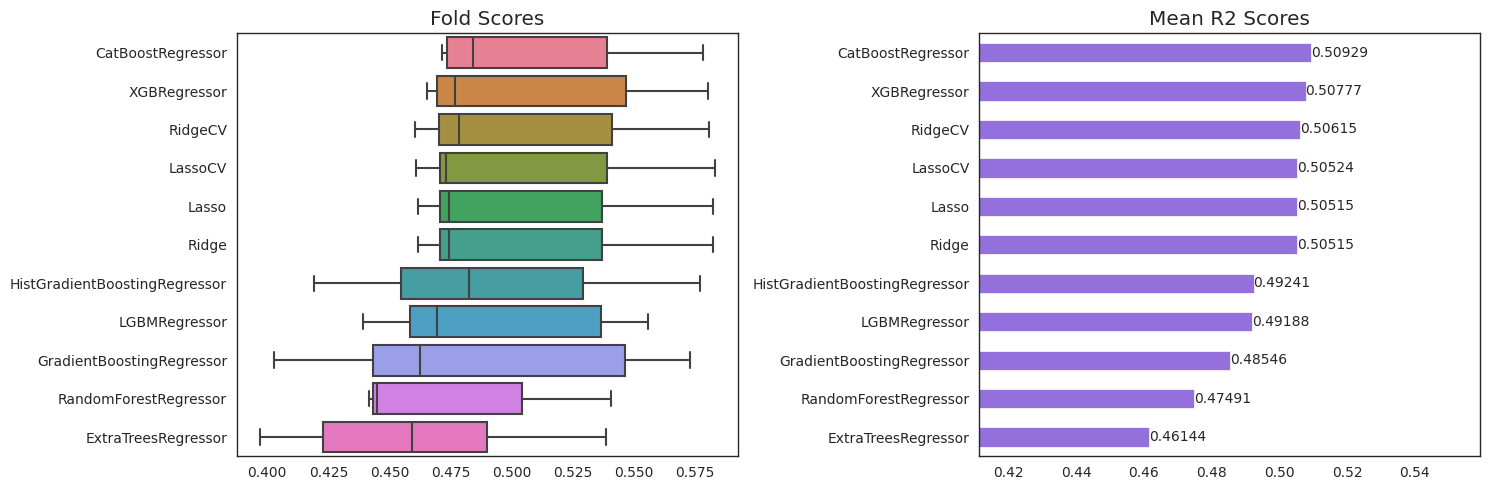

In [36]:
df = pd.DataFrame(model_scores)

sns.set_style("white") 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, orient='h', palette='husl', ax=axes[0], order=df.mean().sort_values(ascending=False).index.tolist())
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('') 
axes[0].set_ylabel('')

mean_scores = df.mean().sort_values(ascending=True)
mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
axes[1].set_title('Mean R2 Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
for j, score in enumerate(mean_scores):
    axes[1].text(score, j, f'{score:.5f}', ha='left', va='center')
axes[1].set_xlim(mean_scores.min() - 0.05, mean_scores.max() + 0.05)
    
plt.tight_layout()
plt.show()